In [1]:
import sys

sys.path.append("..")

In [2]:
import jax

if not jax._src.xla_bridge.backends_are_initialized():
    jax.config.update("jax_num_cpu_devices", 8)
print(f"You have 8 “fake” JAX devices now: {jax.devices()}")


You have 8 “fake” JAX devices now: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [3]:
import jax.numpy as jnp
from flax import nnx
from jax.sharding import AxisType

from src.modules.lstm import (
    LSTMForecaster,
    LSTMForecasterConfig,
    LSTMForecasterShardings,
)

from src.utils.viz import plot_forecast


In [4]:
config = LSTMForecasterConfig(
    hidden_features=16,
    num_metrics=3,
    head_bias=True,
    horizon=10,
    num_heads=4,
)

shardings = LSTMForecasterShardings()
mesh = jax.make_mesh(
    (1, 8),
    ("dp", "tp"),
    axis_types=(AxisType.Auto, AxisType.Auto),
)


rngs = nnx.Rngs(123)


jax.set_mesh(mesh)

In [5]:
with jax.set_mesh(mesh):
    model = LSTMForecaster(
        config=config,
        shardings=shardings,
        rngs=rngs,
        dtype=jnp.float32,
        param_dtype=jnp.float32,
    )

In [6]:
nnx.display(model)

In [7]:
model.rnn.cell.dense_i.kernel[0, 0]

Array(-0.55811375, dtype=float32)

In [8]:
batch = 5
num_devices = 6
timesteps = 16

input = jax.random.normal(
    rngs(),
    shape=(batch, num_devices, config.num_metrics, timesteps),
)

In [9]:
# Split input into context (first half) and ground truth (second half)
context = input[:, :, :, : timesteps // 2]
ground_truth = input[:, :, :, timesteps // 2 :]

print(f"Context shape: {context.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

Context shape: (5, 6, 3, 8)
Ground truth shape: (5, 6, 3, 8)


In [10]:
# Run autoregressive forecasting for 8 steps
forecasts = model(context)

print(f"Forecasts shape: {forecasts.prediction.shape}")

Forecasts shape: (5, 6, 10, 3)


<Axes: title={'center': 'Forecast for Device 0, Metric 5'}, xlabel='Time Step', ylabel='Value'>

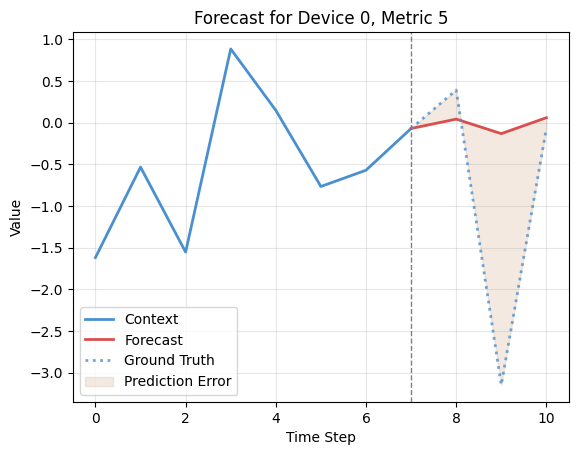

In [11]:
batch_id = 0
metric_id, device_id = 5, 0

# Select specific batch, device, and metric for visualization
t_context = context[batch_id, device_id, metric_id, :]
t_forecast = forecasts.prediction[batch_id, device_id, metric_id, :]
t_ground_truth = ground_truth[batch_id, device_id, metric_id, :]

plot_forecast(
    context=t_context,
    forecasts=t_forecast,
    ground_truth=t_ground_truth,
    title=f"Forecast for Device {device_id}, Metric {metric_id}",
)